### SCORING DRAGONS

Dragons' performance over different Mountain Ranges and also on various sites using thier body length.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
data = pd.read_csv('../datasets/dragons.csv', index_col = None)
data = data.iloc[:,1:]
data.head()

,testScore,bodyLength,mountainRange,site
0,16.147309,165.548520,Bavarian,a
1,33.886183,167.559314,Bavarian,a
2,6.038333,165.882952,Bavarian,a
3,18.838821,167.685525,Bavarian,a
4,33.862328,169.959681,Bavarian,a


<AxesSubplot:xlabel='bodyLength', ylabel='testScore'>

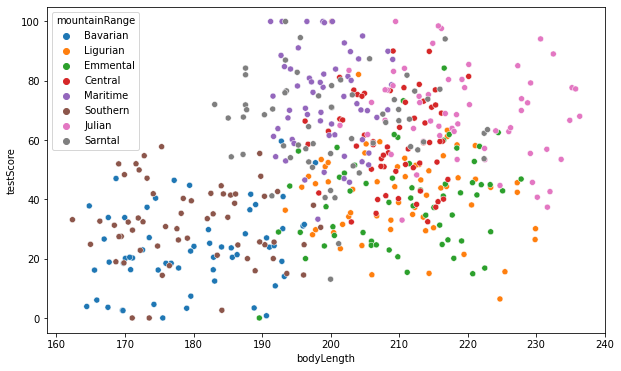

In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="bodyLength", y="testScore", data=data, hue="mountainRange")

<AxesSubplot:xlabel='mountainRange', ylabel='testScore'>

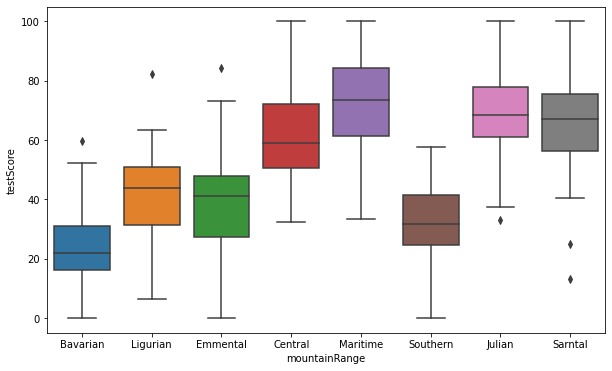

In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="mountainRange", y="testScore", data=data)

In [5]:
X = data.iloc[:,1:]
y = data.iloc[:,0]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
from sklearn.preprocessing import OrdinalEncoder
label_X_train = X_train.copy()
label_X_test = X_test.copy()

object_cols = ["mountainRange", "site"]

ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_test[object_cols] = ordinal_encoder.transform(X_test[object_cols])

# Linear regression considering predictors as fixed effect

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

pipe = Pipeline([('Scaler', MinMaxScaler()), ('Regression', LinearRegression(fit_intercept=True))])
pipe.fit(label_X_train, y_train)

y_pred = pipe.predict(label_X_test)

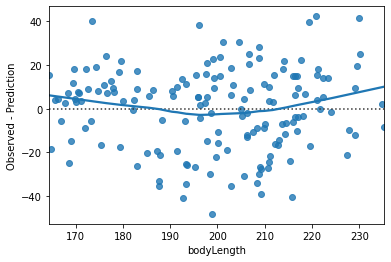

In [8]:
performance = pd.DataFrame()
performance["residuals"] = pipe.predict(label_X_test) - y_test
performance["bodyLength"] = data.bodyLength
performance["predicted"] = pipe.predict(label_X_test)

ax = sns.residplot(x = "bodyLength", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [9]:
from sklearn.metrics import r2_score

y_predict = pipe.predict(label_X_test)
RMSE = np.sqrt(((y_test-y_predict)**2).values.mean())
print("RMSE: ", RMSE)
print("R2: ", r2_score(y_test, y_pred))

RMSE:  18.661204945631678
R2:  0.3280309373392011


# Now using MEM

In [10]:
data_mem = data.copy()
object_cols = ["mountainRange", "site"]
ordinal_encoder = OrdinalEncoder()
data_mem[object_cols] = ordinal_encoder.fit_transform(data_mem[object_cols])

In [11]:
data_mem['mountainRange'] = data_mem['mountainRange'].astype(int)
data_mem['site'] = data_mem['site'].astype(int)
data_mem.sample(5)

,testScore,bodyLength,mountainRange,site
444,64.528711,196.792338,6,1
339,39.512598,179.682751,7,1
29,4.582095,174.221700,0,1
358,14.488204,196.060398,7,2
255,82.251778,199.007122,5,0


In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = sm.MixedLM.from_formula("testScore ~ bodyLength + (1|mountainRange*site)", data_mem, groups = data_mem['mountainRange'])
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    testScore 
No. Observations:      480        Method:                REML      
No. Groups:            8          Scale:                 216.5524  
Min. group size:       60         Log-Likelihood:        -1984.3722
Max. group size:       60         Converged:             Yes       
Mean group size:       60.0                                        
-------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025  0.975]
-------------------------------------------------------------------
Intercept               73.386   27.150  2.703 0.007 20.172 126.600
bodyLength              -0.169    0.109 -1.543 0.123 -0.383   0.046
1 | mountainRange        1.878    3.487  0.539 0.590 -4.956   8.713
site                     6.968    1.769  3.940 0.000  3.502  10.435
1 | mountainRange:site  -0.888    0.373 -2.381 0.017 -1.620  -0

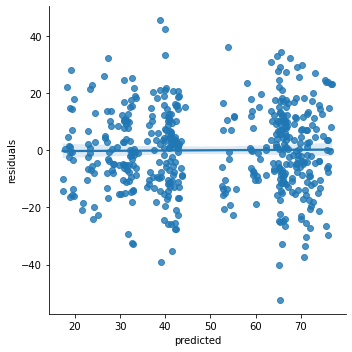

In [13]:
performance_mem = pd.DataFrame()
performance_mem["residuals"] = mdf.resid.values
performance_mem["bodyLength"] = data_mem.bodyLength
performance_mem["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance_mem)

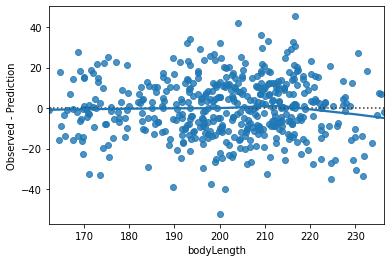

In [14]:
ax = sns.residplot(x = "bodyLength", y = "residuals", data = performance_mem, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [15]:
y_predict = mdf.fittedvalues
y = data.testScore
RMSE = np.sqrt(((y-y_predict)**2).values.mean())
print("RMSE: ", RMSE)
print("R2: ", r2_score(y, y_predict))

RMSE:  14.547282335827154
R2:  0.5994273874692095


## MEM results in reduced RMSE